In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pack_sequence, pad_packed_sequence, pad_sequence

import os
import sys
import pickle
import logging
import random
from pathlib import Path
from math import log, ceil
from typing import List, Tuple, Set, Dict

import numpy as np
import pandas as pd
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('..')
from src.data import prepare_data, prepare_heatmap_data,SOURCE_ASSIST0910_SELF, SOURCE_ASSIST0910_ORIG

sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set1')

In [2]:
# =========================
# PyTorch version & GPU setup
# =========================
print('PyTorch:', torch.__version__)
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device:', dev)

# =========================
# Seed
# =========================
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# =========================
# Parameters
# =========================
model_name = 'LSTM'
sequence_size = 20
epoch_size = 1000
lr = 0.01
batch_size, n_hidden, n_skills, n_layers = 100, 200, 124, 2
n_output = n_skills
PRESERVED_TOKENS = 2  # PAD, SOS
onehot_size = n_skills * 2 + PRESERVED_TOKENS
n_input = ceil(log(2 * n_skills))
# n_input = onehot_size  #

# =========================
# Data
# =========================
train_dl, eval_dl = prepare_data(
    SOURCE_ASSIST0910_ORIG, 'base', n_skills, preserved_tokens='?', min_n=3, max_n=sequence_size, batch_size=batch_size, device=dev, sliding_window=0)

print(train_dl.dataset.tensors[2].size(), eval_dl.dataset.tensors[2].size())

PyTorch: 1.0.1.post2
Using Device: cuda
torch.Size([14549]) torch.Size([3407])


In [3]:
# =========================
# Model
# =========================
class DKT(nn.Module):
    ''' オリジナルのDKT '''
    def __init__(self, dev, model_name, n_input, n_hidden, n_output, n_layers, batch_size, dropout=0.6, bidirectional=False):
        super(DKT, self).__init__()
        self.dev = dev
        self.model_name = model_name
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.n_layers = n_layers
        self.batch_size = batch_size
        
        self.bidirectional = bidirectional
        self.directions = 2 if self.bidirectional else 1
        
        nonlinearity = 'tanh'
        # https://pytorch.org/docs/stable/nn.html#rnn
        if model_name == 'RNN':
            self.rnn = nn.RNN(n_input, n_hidden, n_layers,
                              nonlinearity=nonlinearity, dropout=dropout, bidirectional=self.bidirectional)
        elif model_name == 'LSTM':
            self.lstm = nn.LSTM(n_input, n_hidden, n_layers, dropout=dropout, bidirectional=self.bidirectional)
        else:
            raise ValueError('Model name not supported')
        self.decoder = nn.Linear(n_hidden * self.directions, n_output)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        if self.model_name == 'RNN':
            h0 = self.initHidden0()
            out, _hn = self.rnn(input, h0)
        elif self.model_name == 'LSTM':
            h0 = self.initHidden0()
            c0 = self.initC0()
            out, (_hn, _cn) = self.lstm(input, (h0, c0))
        # top_n, top_i = out.topk(1)
        # decoded = self.decoder(out.contiguous().view(out.size(0) * out.size(1), out.size(2)))
        out = self.decoder(out)
        # decoded = self.sigmoid(decoded)

        return out
    
    def initHidden0(self):
        return torch.zeros(self.n_layers * self.directions, self.batch_size, self.n_hidden).to(self.dev)

    def initC0(self):
        return torch.zeros(self.n_layers * self.directions, self.batch_size, self.n_hidden).to(self.dev)
    
    
# =========================
# Prepare and Train
# =========================
assert model_name in {'LSTM', 'RNN'}
model = DKT(dev, model_name, n_input, n_hidden, n_output, n_layers, batch_size)
model.to(dev)
loss_func = nn.BCELoss()
opt = optim.SGD(model.parameters(), lr=lr)


def loss_batch(model, loss_func, *args, opt=None):
    # Unpack data from DataLoader
    xs, yq, ya = args
    input = xs
    compressed_sensing = True
    if compressed_sensing and onehot_size != n_input:
        torch.manual_seed(SEED)
        cs_basis = torch.randn(onehot_size, n_input).to(dev)
        input = torch.mm(
            input.contiguous().view(-1, onehot_size), cs_basis)
        # https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn
        # inputの説明を見ると、input of shape (seq_len, batch, input_size)　とある
        input = input.view(batch_size, sequence_size, n_input)
    input = input.permute(1, 0, 2)

    target = ya

    out = model(input)

    pred = torch.sigmoid(out[-1])  # [0, 1]区間にする
    prob = torch.max(pred * yq, 1)[0]
    predicted = prob
    actual = target
    loss = loss_func(prob, target)  # TODO: 最後の1個だけじゃなくて、その他も損失関数に利用したら？
    
    predicted_ks = pred

    if opt:
        # バックプロバゲーション
        opt.zero_grad()
        loss.backward()
        opt.step()
        
#     print(predicted_ks.shape)
        
    return loss.item(), len(ya), predicted, actual, predicted_ks

## Main

starting


Level 25:dkt log:TRAIN Epoch: 100 Loss: 0.5326354748216169
Level 25:dkt log:TRAIN Epoch: 100 AUC: 0.7533162110320696
Level 25:dkt log:EVAL  Epoch: 100 Loss: 0.5572257594150656
Level 25:dkt log:EVAL  Epoch: 100 AUC: 0.7281113043478261
Level 25:dkt log:TRAIN Epoch: 200 Loss: 0.4852078006185334
Level 25:dkt log:TRAIN Epoch: 200 AUC: 0.7933022001550898
Level 25:dkt log:EVAL  Epoch: 200 Loss: 0.5227677291807007
Level 25:dkt log:EVAL  Epoch: 200 AUC: 0.7636539130434783
Level 25:dkt log:TRAIN Epoch: 300 Loss: 0.4692421080223445
Level 25:dkt log:TRAIN Epoch: 300 AUC: 0.8082426622947317
Level 25:dkt log:EVAL  Epoch: 300 Loss: 0.5077781659715316
Level 25:dkt log:EVAL  Epoch: 300 AUC: 0.7738490821256039
Level 25:dkt log:TRAIN Epoch: 400 Loss: 0.4602797820650298
Level 25:dkt log:TRAIN Epoch: 400 AUC: 0.8165348384659321
Level 25:dkt log:EVAL  Epoch: 400 Loss: 0.5000462098156705
Level 25:dkt log:EVAL  Epoch: 400 AUC: 0.7816701449275363
Level 25:dkt log:TRAIN Epoch: 500 Loss: 0.4521911409137578
Level

100 100 100


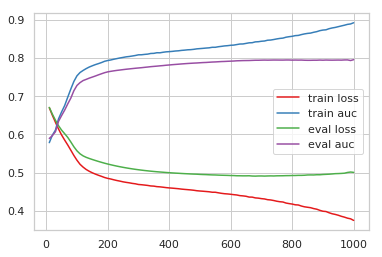

Max Eval AUC: 0.795512077294686


In [4]:
def main():
    debug = False
    logging.basicConfig()
    logger = logging.getLogger('dkt log')
    logger.setLevel(logging.INFO + 1)
    train_loss_list = []
    train_auc_list = []
    eval_loss_list = []
    eval_auc_list = []
    eval_recall_list = []
    eval_f1_list = []
    x = []
    for epoch in range(1, epoch_size + 1):
        print_train = epoch % 10 == 0
        print_eval = epoch % 10 == 0
        print_auc = epoch % 10 == 0

        # ======
        # TRAIN
        # ======
        model.train()

        val_prob = []
        val_targ = []
        current_epoch_train_loss = []
        for args in train_dl:
            loss_item, length, predicted, actual, predicted_ks = loss_batch(model, loss_func, *args, opt=opt)
            val_prob.append(predicted)
            val_targ.append(actual)
            current_epoch_train_loss.append(loss_item)

            # stop at first batch if debug
            if debug:
                break
                
        if print_train:
            loss = np.array(current_epoch_train_loss)
            logger.log(logging.INFO + (5 if epoch % 100 == 0 else 0),
                       'TRAIN Epoch: {} Loss: {}'.format(epoch, loss.mean()))
            train_loss_list.append(loss.mean())
            
            # AUC, Recall, F1
            # TRAINの場合、勾配があるから処理が必要
            y = torch.cat(val_targ).cpu().detach().numpy()
            pred = torch.cat(val_prob).cpu().detach().numpy()
            # AUC
            fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
            logger.log(logging.INFO + (5 if epoch % 100 == 0 else 0), 
                       'TRAIN Epoch: {} AUC: {}'.format(epoch, metrics.auc(fpr, tpr)))
            train_auc_list.append(metrics.auc(fpr, tpr))


        # ======
        # EVAL
        # ======
        if print_eval:
            with torch.no_grad():
                model.eval()

                val_prob = []
                val_targ = []
                current_eval_loss = []
                for args in eval_dl:
                    loss_item, length, predicted, actual, predicted_ks = loss_batch(model, loss_func, *args, opt=None)
                    val_prob.append(predicted)
                    val_targ.append(actual)
                    current_eval_loss.append(loss_item)
                    
                    # stop at first batch if debug
                    if debug:
                        break
                        
                loss = np.array(current_eval_loss)
                logger.log(logging.INFO + (5 if epoch % 100 == 0 else 0), 
                           'EVAL  Epoch: {} Loss: {}'.format(epoch,  loss.mean()))
                eval_loss_list.append(loss.mean())

                # AUC, Recall, F1
                if print_auc:
                    y = torch.cat(val_targ).cpu()
                    pred = torch.cat(val_prob).cpu()
                    # AUC
                    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
                    logger.log(logging.INFO + (5 if epoch % 100 == 0 else 0), 
                               'EVAL  Epoch: {} AUC: {}'.format(epoch, metrics.auc(fpr, tpr)))
                    eval_auc_list.append(metrics.auc(fpr, tpr))
                    # Recall
                    logger.debug('EVAL  Epoch: {} Recall: {}'.format(epoch, metrics.recall_score(y, pred.round())))
                    # F1 score
                    logger.debug('EVAL  Epoch: {} F1 score: {}'.format(epoch, metrics.f1_score(y, pred.round())))
        
        if epoch % 10 == 0:
            x.append(epoch)

        
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, train_loss_list, label='train loss')
    ax.plot(x, train_auc_list, label='train auc')
    ax.plot(x, eval_loss_list, label='eval loss')
    ax.plot(x, eval_auc_list, label='eval auc')
    ax.legend()
    print(len(train_loss_list), len(eval_loss_list), len(eval_auc_list))
    plt.show()
    
    print(f'Max Eval AUC: {max(eval_auc_list)}')


if __name__ == '__main__':
    print('starting')
    main()

In [15]:
f'{0.7785775736240735:<8.4f}'

'0.7786  '

In [7]:

import datetime
now = datetime.datetime.now().strftime('%Y_%m%d_%H%M')

torch.save(model.state_dict(), '/home/qqhann/qqhann-paper/ECML2019/dkt_neo/models/rnn_' + now + '.' + str(1000))

# Heatmap

In [5]:
heat_dl = prepare_heatmap_data(
    SOURCE_ASSIST0910_ORIG, 'base', n_skills, PRESERVED_TOKENS, min_n=3, max_n=sequence_size, batch_size=batch_size, device=dev, sliding_window=0)


In [5]:
heat_dl.dataset.tensors

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

In [6]:
model

DKT(
  (lstm): LSTM(6, 200, num_layers=2, dropout=0.6)
  (decoder): Linear(in_features=200, out_features=124, bias=True)
)

In [6]:
# if model_name in {'LSTM', 'RNN'}:
#     model = DKT(dev, model_name, n_input, n_hidden, n_output, n_layers, batch_size)
# elif model_name in {'AttentionalDKT'}:
#     model = AttentionalDKT(dev, model_name, n_input, n_hidden, n_output, n_layers, batch_size)
# model.to(dev)

# # Load model
# # ----------
# load_model = None
# load_model = '/home/qqhann/qqhann-paper/ECML2019/dkt_neo/models/rnn_2019_0405_1618.1000'
# if load_model:
#     model.load_state_dict(torch.load(load_model))
#     model = model.to(dev)
# # ----------

def heatmap():
    logging.basicConfig()
    logger = logging.getLogger('dkt log')
    logger.setLevel(logging.INFO + 1)
    train_loss_list = []
    train_auc_list = []
    eval_loss_list = []
    eval_auc_list = []
    eval_recall_list = []
    eval_f1_list = []
    x = []
    # ======
    # HEATMAP
    # ======
    with torch.no_grad():
        model.eval()

        all_out_prob = []
        val_prob = []
        val_targ = []
        current_eval_loss = []
        for args in eval_dl:
            loss_item, length, predicted, actual, predicted_ks = loss_batch(model, loss_func, *args, opt=None)
            val_prob.append(predicted)
            val_targ.append(actual)
            current_eval_loss.append(loss_item)
            
            all_out_prob.append(predicted_ks)


        loss = np.array(current_eval_loss)
#         logger.log(logging.INFO + (5 if epoch % 100 == 0 else 0), 
#                    'EVAL  Epoch: {} Loss: {}'.format(epoch,  loss.mean()))
        eval_loss_list.append(loss.mean())

        # AUC, Recall, F1
        y = torch.cat(val_targ).cpu()
        pred = torch.cat(val_prob).cpu()
        # AUC
        fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
        eval_auc_list.append(metrics.auc(fpr, tpr))
#         # Recall
#         logger.debug('EVAL  Epoch: {} Recall: {}'.format(epoch, metrics.recall_score(y, pred.round())))
#         # F1 score
#         logger.debug('EVAL  Epoch: {} F1 score: {}'.format(epoch, metrics.f1_score(y, pred.round())))
 
    print(eval_auc_list)
    return all_out_prob


if __name__ == '__main__':
    all_out_prob = heatmap()
    print('finish')

[0.795512077294686]
finish


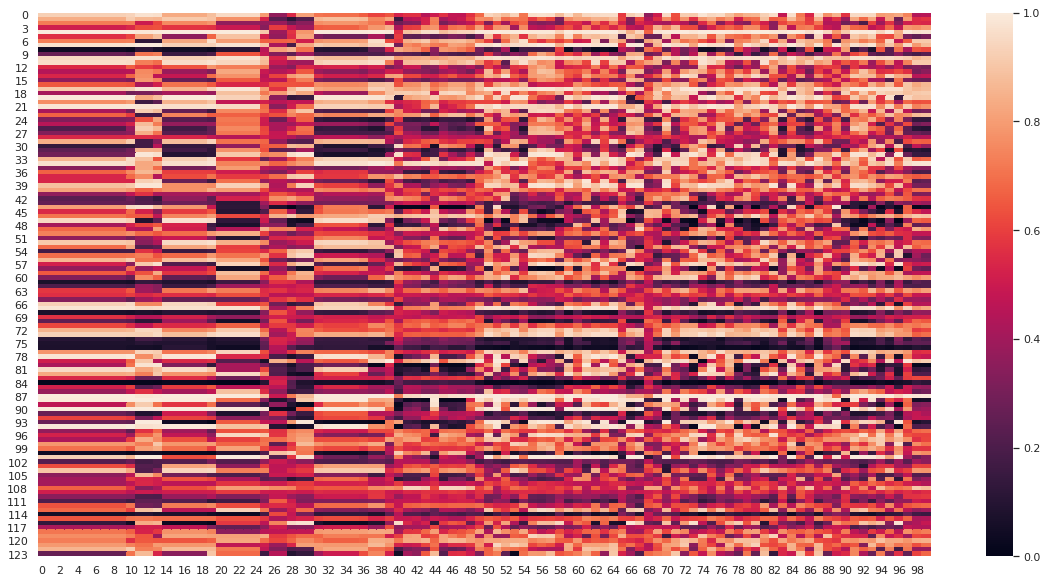

In [7]:
_d = all_out_prob[-1].squeeze(1).t().cpu()
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(_d, vmin=0, vmax=1, ax=ax)